In [18]:
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG16  # Use a pre-trained model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
# Download dataset (if not already downloaded)
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")
print("Path to dataset files:", path)

# Define dataset paths
dataset_path = "/teamspace/studios/this_studio/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1/Data"

Path to dataset files: /teamspace/studios/this_studio/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1


In [20]:
# Image size and batch size
img_size = (224, 224)
batch_size = 32

# Data Augmentation (Crucial for small datasets)
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # More rotation
    width_shift_range=0.3, # More shift
    height_shift_range=0.3, # More shift
    shear_range=0.3, # More shear
    zoom_range=0.3, # More zoom
    horizontal_flip=True,
    brightness_range=[0.8, 1.2], # Brightness adjustment
    fill_mode='nearest'
)

In [21]:
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation

train_generator = train_datagen.flow_from_directory(
    dataset_path + "/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    dataset_path + "/valid",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
).map(lambda x, y: (x / 255.0, y)) # Normalize test data

# Save the class names for later use
class_labels = test_dataset_raw.class_names

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 files belonging to 4 classes.


In [22]:
num_classes = 4

# Transfer Learning with VGG16 (State-of-the-art approach)
base_model = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Freeze the base model initially

# model = models.Sequential([
#     base_model,
#     layers.Flatten(),
#     layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)), # L2 regularization
#     layers.Dropout(0.5),
#     layers.Dense(num_classes, activation='softmax')
# ])

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(), # Batch Normalization
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,564,356 (105.15 MB)

 Trainable params: 12,848,644 (49.01 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [23]:
# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

In [24]:
# Compile model (using a lower learning rate initially)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Start with a smaller LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
# Train model (using the generators and callbacks)
epochs = 50  # Increased epochs

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4445 - loss: 2.7799 - val_accuracy: 0.3906 - val_loss: 3.1661 - learning_rate: 0.0010
Epoch 2/50
 1/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5938 - loss: 1.7815

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.5938 - loss: 1.7815 - val_accuracy: 0.4375 - val_loss: 3.3454 - learning_rate: 0.0010
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4893 - loss: 2.1331 - val_accuracy: 0.5156 - val_loss: 4.1107 - learning_rate: 0.0010
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.5938 - loss: 1.8244 - val_accuracy: 0.5312 - val_loss: 3.9150 - learning_rate: 0.0010
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5766 - loss: 1.8823 - val_accuracy: 0.5625 - val_loss: 2.1202 - learning_rate: 5.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.5625 - loss: 1.6316 - val_accuracy: 0.5781 - val_loss: 1.9608 - learning_rate: 5.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5841 - loss: 1.7487 - val_accuracy: 0.6719 - val_loss: 1.6629 - learning_rate: 5.0000e-04
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.7188 - loss: 1.4465 - val_a

In [26]:
# Fine-tuning (Unfreeze some layers of VGG16)
base_model.trainable = True

for layer in base_model.layers[:15]:  # Freeze the earlier layers
    layer.trainable = False

# Recompile with an even lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Very small LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with fine-tuning
fine_tuning_epochs = 20

fine_tuning_history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=fine_tuning_epochs + epochs,  # Total epochs
    initial_epoch=epochs, #Start from the previous epoch
    callbacks=[early_stopping, reduce_lr]
)


Epoch 51/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.5951 - loss: 1.8210 - val_accuracy: 0.7188 - val_loss: 1.3948 - learning_rate: 1.0000e-04
Epoch 52/70
 1/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.3750 - loss: 1.9804

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.3750 - loss: 1.9804 - val_accuracy: 0.7188 - val_loss: 1.4209 - learning_rate: 1.0000e-04
Epoch 53/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5625 - loss: 1.6643 - val_accuracy: 0.4531 - val_loss: 2.5037 - learning_rate: 1.0000e-04
Epoch 54/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.5938 - loss: 1.7776 - val_accuracy: 0.4219 - val_loss: 2.7147 - learning_rate: 1.0000e-04
Epoch 55/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.6531 - loss: 1.4903 - val_accuracy: 0.5469 - val_loss: 1.7167 - learning_rate: 1.0000e-04
Epoch 56/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.7500 - loss: 1.1403 - val_accuracy: 0.5781 - val_loss: 1.6149 - learning_rate: 1.0000e-04


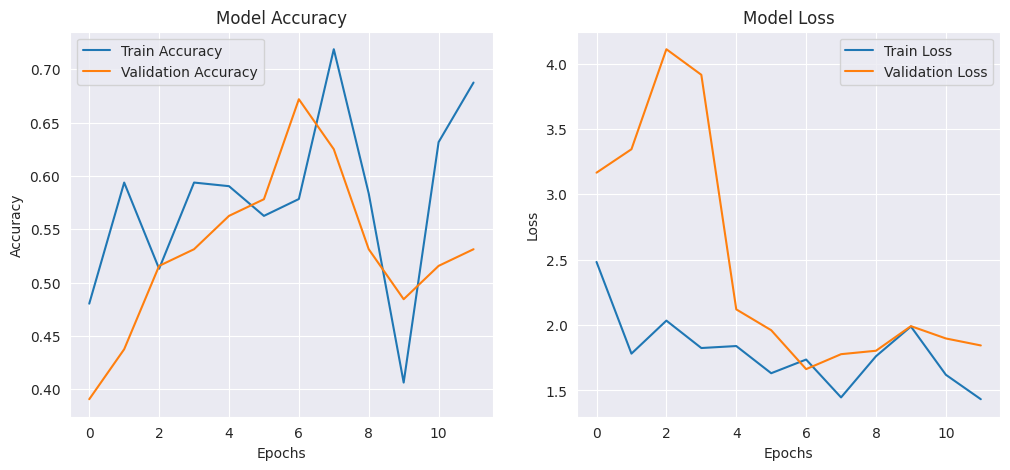

In [28]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [29]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Save the model
model.save("models/chest_ct_scan_model.h5") # Save the model for future use

10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5754 - loss: 1.8054


Test Accuracy: 0.5714


10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


2025-02-12 11:10:55.570752: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6405 - loss: 1.0200
Test Accuracy: 64.76%


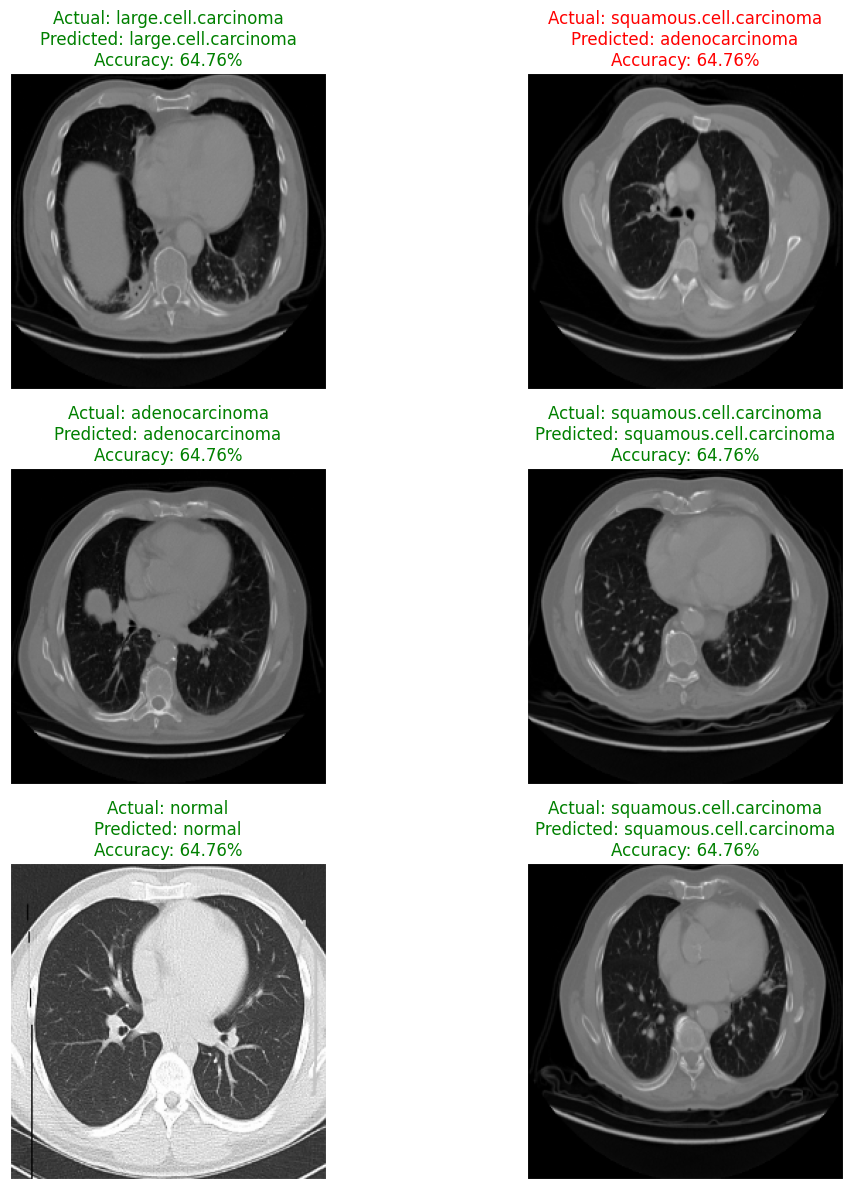

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")


# Save the class names for later use
class_labels = test_dataset_raw.class_names

normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False):
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.cache().shuffle(1000)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

# Prepare the test dataset (this version will lose the 'class_names' attribute,
# but we already stored them in `class_labels`)
test_dataset = prepare(test_dataset_raw)


predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# -------------------------------------------------------------------
# 4. Extract True Labels and Images from the Dataset
# -------------------------------------------------------------------
# Since `test_dataset` is a tf.data.Dataset, iterate over it to collect images and labels
test_images = []
test_labels = []

for images, labels in test_dataset:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

# Concatenate all batches into single arrays
test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Convert one-hot encoded labels to integer class indices
true_classes = np.argmax(test_labels, axis=1)

# -------------------------------------------------------------------
# 5. Evaluate the Model on Test Data
# -------------------------------------------------------------------
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# -------------------------------------------------------------------
# 6. Plot Sample Test Images with Their Predictions
# -------------------------------------------------------------------
plt.figure(figsize=(12, 12))
num_images_to_plot = 6  # Adjust the number of images to plot as desired

for i in range(num_images_to_plot):
    plt.subplot(3, 2, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Get the i-th image (images are already normalized to [0, 1])
    img = test_images[i]
    plt.imshow(img)

    # Get the actual and predicted labels
    actual_label = class_labels[true_classes[i]]
    predicted_label = class_labels[predicted_classes[i]]

    # Build the title string showing actual vs. predicted labels and the overall test accuracy
    title = f"Actual: {actual_label}\nPredicted: {predicted_label}\nAccuracy: {test_accuracy * 100:.2f}%"
    color = "green" if predicted_label == actual_label else "red"
    plt.title(title, color=color)

plt.tight_layout()
plt.show()
